# 01_imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize
import seaborn as sns
import plotly.express as px
import gdown

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.sparse import csr_matrix, vstack

# 02_data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

drop Unnamed: 0 column, reset index

In [4]:
file_id = '13ssoJ5XCm1GbKZSACRlflpTciuBMhM9m'
download_url = f'https://drive.google.com/uc?id={file_id}'
output = 'data.csv'

gdown.download(download_url, output, quiet=False)

df = pd.read_csv(output, sep = '\t')

Downloading...
From (original): https://drive.google.com/uc?id=13ssoJ5XCm1GbKZSACRlflpTciuBMhM9m
From (redirected): https://drive.google.com/uc?id=13ssoJ5XCm1GbKZSACRlflpTciuBMhM9m&confirm=t&uuid=fde63323-02b7-475d-8cbf-8e18917a4c98
To: /content/data.csv
100%|██████████| 483M/483M [00:06<00:00, 69.8MB/s]
<ipython-input-4-b76c573f06dc>:7: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output, sep = '\t')


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df.reset_index(drop=True, inplace=True)

In [7]:
df.shape

(455085, 27)

In [8]:
print(df['chart'].value_counts(normalize=True))

chart
top200     0.800264
viral50    0.199736
Name: proportion, dtype: float64


## 02_1 inconsistency in song numbers

In [9]:
grouped_df_2 = df.groupby(['date', 'chart']).size().reset_index().rename(columns = {0: 'number_of_songs_per_chart'})

In [10]:
query_2 = grouped_df_2.query('chart == "viral50"').query("number_of_songs_per_chart != 50").sort_values(by="number_of_songs_per_chart", ascending=False)
print(query_2)
print(len(query_2))

            date    chart  number_of_songs_per_chart
490   2017-09-05  viral50                         52
492   2017-09-06  viral50                         52
494   2017-09-07  viral50                         52
496   2017-09-08  viral50                         52
498   2017-09-09  viral50                         52
...          ...      ...                        ...
1995  2019-09-29  viral50                         49
1993  2019-09-28  viral50                         49
1991  2019-09-27  viral50                         49
1989  2019-09-26  viral50                         49
3547  2021-11-14  viral50                         49

[95 rows x 3 columns]
95


In [11]:
query_3 = grouped_df_2.query('chart == "top200"').query("number_of_songs_per_chart != 200").sort_values(by="number_of_songs_per_chart", ascending=False)
print(query_3)
print(len(query_3))

           date   chart  number_of_songs_per_chart
571  2017-10-16  top200                        201
573  2017-10-17  top200                        201
575  2017-10-18  top200                        201
577  2017-10-19  top200                        201
400  2017-07-22  top200                        199
402  2017-07-23  top200                        199
619  2017-11-09  top200                        199
621  2017-11-10  top200                        199
623  2017-11-11  top200                        199
625  2017-11-12  top200                        199
627  2017-11-13  top200                        199
629  2017-11-14  top200                        199
396  2017-07-20  top200                        196
398  2017-07-21  top200                        196
14


In [12]:
print("Top 200 min and max date:")
print(df.query('chart == "top200"')['date'].min())
print(df.query('chart == "top200"')['date'].max())

print('\n')

print("Viral 50 min and max date:")
print(df.query('chart == "viral50"')['date'].min())
print(df.query('chart == "viral50"')['date'].max())

Top 200 min and max date:
2017-01-01
2021-12-31


Viral 50 min and max date:
2017-01-01
2021-12-31


In [13]:
grouped_df_2

date    chart  number_of_songs_per_chart
0     2017-01-01   top200                        200
1     2017-01-01  viral50                         50
2     2017-01-02   top200                        200
3     2017-01-02  viral50                         50
4     2017-01-03   top200                        200
...          ...      ...                        ...
3635  2021-12-29  viral50                         50
3636  2021-12-30   top200                        200
3637  2021-12-30  viral50                         50
3638  2021-12-31   top200                        200
3639  2021-12-31  viral50                         50

[3640 rows x 3 columns]

## 02_2 missing dates for both playlists

In [14]:
df['date'] = pd.to_datetime(df['date'])

start_date = df['date'].min()
end_date = df['date'].max()

print(start_date)
print(end_date)

2017-01-01 00:00:00
2021-12-31 00:00:00


In [15]:
all_dates = pd.date_range(start=start_date, end=end_date)
missing_dates_viral50 = all_dates.difference(df.query('chart == "viral50"')['date'])

print("Brakujące daty:")
print(missing_dates_viral50)
print(len(missing_dates_viral50))

Brakujące daty:
DatetimeIndex(['2017-06-04', '2017-07-23', '2019-01-14', '2019-01-15',
               '2019-04-09', '2019-11-15', '2019-11-16'],
              dtype='datetime64[ns]', freq=None)
7


In [16]:
all_dates = pd.date_range(start=start_date, end=end_date)
missing_dates_top200 = all_dates.difference(df.query('chart == "top200"')['date'])

print("Brakujące daty:")
print(missing_dates_top200)
print(len(missing_dates_top200))

Brakujące daty:
DatetimeIndex(['2017-05-30', '2017-05-31', '2017-06-02', '2021-12-01',
               '2021-12-02'],
              dtype='datetime64[ns]', freq=None)
5


In [17]:
df['chart'].value_counts()

chart
top200     364188
viral50     90897
Name: count, dtype: int64

In [18]:
df.query('chart == "top200"').isna().sum()

title                    0
rank                     0
date                     0
artist                   0
url                      0
chart                    0
trend                    0
streams                  0
track_id               107
album                  107
popularity             107
duration_ms            107
explicit               107
release_date           107
available_markets      107
af_danceability        107
af_energy              107
af_key                 107
af_loudness            107
af_mode                107
af_speechiness         107
af_acousticness        107
af_instrumentalness    107
af_liveness            107
af_valence             107
af_tempo               107
af_time_signature      107
dtype: int64

In [19]:
df.query('chart == "viral50"').isna().sum()

title                      0
rank                       0
date                       0
artist                     0
url                        0
chart                      0
trend                      0
streams                90897
track_id                7159
album                   7233
popularity              7159
duration_ms             7159
explicit                7159
release_date            7159
available_markets       7159
af_danceability         7159
af_energy               7159
af_key                  7159
af_loudness             7159
af_mode                 7159
af_speechiness          7159
af_acousticness         7159
af_instrumentalness     7159
af_liveness             7159
af_valence              7159
af_tempo                7159
af_time_signature       7159
dtype: int64

Dane chart = viral 50 nie zawierają danych w kolumnie stream. Tylko dane chart = top 200 zawierają dane stream.

# 03_EDA

info, isna, describe

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455085 entries, 0 to 455084
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   title                455085 non-null  object        
 1   rank                 455085 non-null  int64         
 2   date                 455085 non-null  datetime64[ns]
 3   artist               455085 non-null  object        
 4   url                  455085 non-null  object        
 5   chart                455085 non-null  object        
 6   trend                455085 non-null  object        
 7   streams              364188 non-null  float64       
 8   track_id             447819 non-null  object        
 9   album                447745 non-null  object        
 10  popularity           447819 non-null  float64       
 11  duration_ms          447819 non-null  float64       
 12  explicit             447819 non-null  object        
 13  release_date  

In [21]:
df.isna().sum()

title                      0
rank                       0
date                       0
artist                     0
url                        0
chart                      0
trend                      0
streams                90897
track_id                7266
album                   7340
popularity              7266
duration_ms             7266
explicit                7266
release_date            7266
available_markets       7266
af_danceability         7266
af_energy               7266
af_key                  7266
af_loudness             7266
af_mode                 7266
af_speechiness          7266
af_acousticness         7266
af_instrumentalness     7266
af_liveness             7266
af_valence              7266
af_tempo                7266
af_time_signature       7266
dtype: int64

In [22]:
df[df['chart'] == 'viral50'].isna().sum()

title                      0
rank                       0
date                       0
artist                     0
url                        0
chart                      0
trend                      0
streams                90897
track_id                7159
album                   7233
popularity              7159
duration_ms             7159
explicit                7159
release_date            7159
available_markets       7159
af_danceability         7159
af_energy               7159
af_key                  7159
af_loudness             7159
af_mode                 7159
af_speechiness          7159
af_acousticness         7159
af_instrumentalness     7159
af_liveness             7159
af_valence              7159
af_tempo                7159
af_time_signature       7159
dtype: int64

In [23]:
df[df['chart'] == 'top200'].isna().sum()

title                    0
rank                     0
date                     0
artist                   0
url                      0
chart                    0
trend                    0
streams                  0
track_id               107
album                  107
popularity             107
duration_ms            107
explicit               107
release_date           107
available_markets      107
af_danceability        107
af_energy              107
af_key                 107
af_loudness            107
af_mode                107
af_speechiness         107
af_acousticness        107
af_instrumentalness    107
af_liveness            107
af_valence             107
af_tempo               107
af_time_signature      107
dtype: int64

In [24]:
df.describe()

rank                           date       streams  \
count  455085.000000                         455085  3.641880e+05   
mean       85.523832  2019-07-02 20:23:49.890240512  3.902733e+05   
min         1.000000            2017-01-01 00:00:00  1.224880e+05   
25%        32.000000            2018-04-03 00:00:00  2.361558e+05   
50%        76.000000            2019-07-03 00:00:00  2.947910e+05   
75%       138.000000            2020-10-01 00:00:00  4.346858e+05   
max       200.000000            2021-12-31 00:00:00  6.146233e+06   
std        60.065392                            NaN  2.788001e+05   

          popularity   duration_ms  af_danceability      af_energy  \
count  447819.000000  4.478190e+05    447819.000000  447819.000000   
mean       54.025289  2.017023e+05         0.695851       0.604684   
min         0.000000  0.000000e+00         0.059300       0.000138   
25%        36.000000  1.733250e+05         0.605000       0.504000   
50%        67.000000  1.995060e+05         0.714000       0.610000   
75%        77.000000  2.244490e+05         0.798000       0.724000   
max        96.000000  1.355938e+06         0.981000       0.999000   
std        30.600562  4.755023e+04         0.144934       0.159788   

              af_key    af_loudness        af_mode  af_speechiness  \
count  447819.000000  447819.000000  447819.000000   447819.000000   
mean        5.288061      -6.703126       0.596562        0.135801   
min         0.000000     -38.855000       0.000000        0.022300   
25%         1.000000      -7.893000       0.000000        0.045600   
50%         6.000000      -6.366000       1.000000        0.082400   
75%         8.000000      -5.064000       1.000000        0.200000   
max        11.000000       0.457000       1.000000        0.966000   
std         3.684531       2.473733       0.490588        0.121699   

       af_acousticness  af_instrumentalness    af_liveness     af_valence  \
count    447819.000000        447819.000000  447819.000000  447819.000000   
mean          0.230106             0.012558       0.170668       0.465486   
min           0.000002             0.000000       0.011900       0.026200   
25%           0.040800             0.000000       0.097600       0.306000   
50%           0.139000             0.000000       0.123000       0.453000   
75%           0.341000             0.000015       0.196000       0.620000   
max           0.995000             0.973000       0.972000       0.982000   
std           0.243057             0.079687       0.124719       0.213962   

            af_tempo  af_time_signature  
count  447819.000000      447819.000000  
mean      121.975608           3.962485  
min        40.319000           1.000000  
25%        97.989000           4.000000  
50%       121.975000           4.000000  
75%       142.942000           4.000000  
max       218.150000           5.000000  
std        29.259903           0.306816

## 03_1 scatter

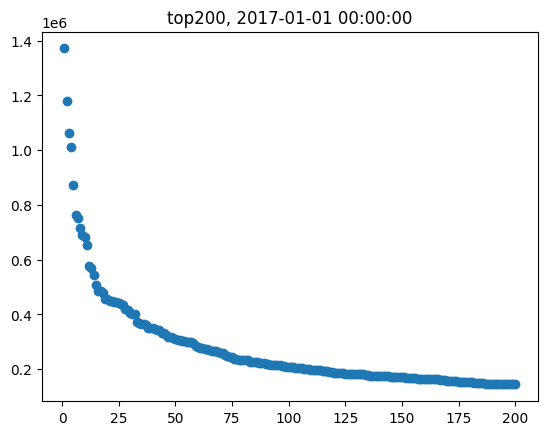

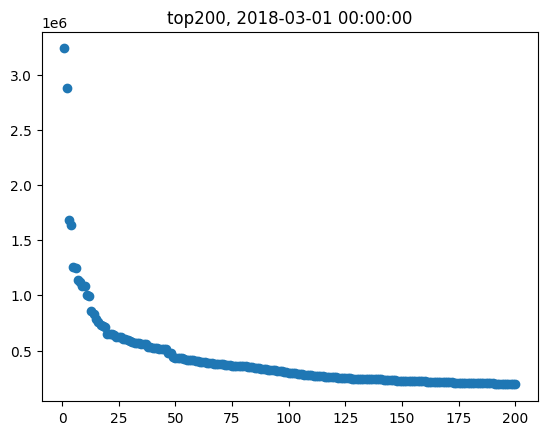

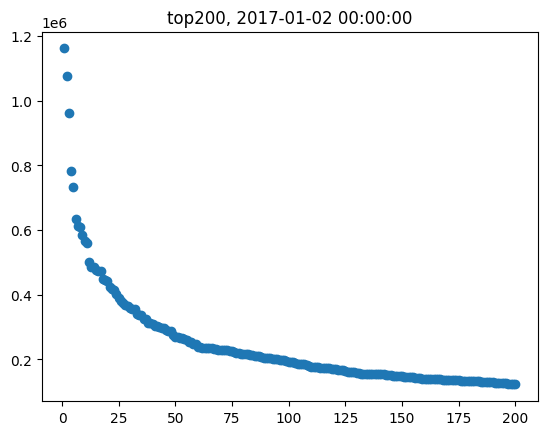

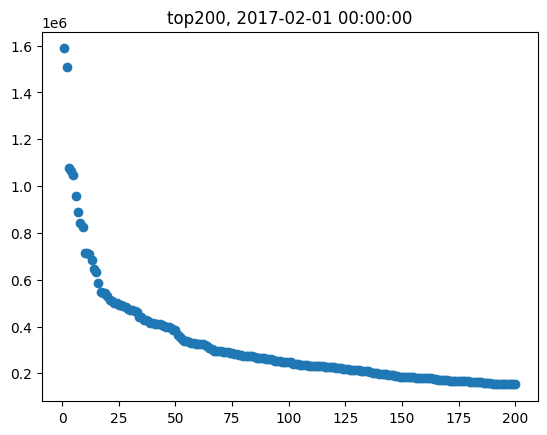

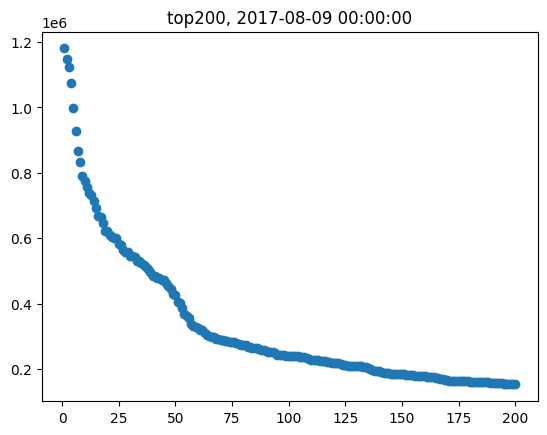

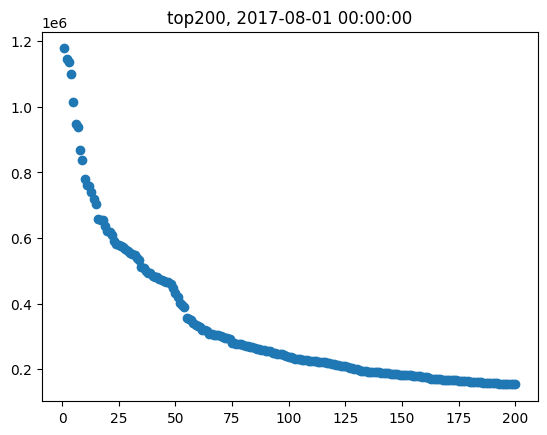

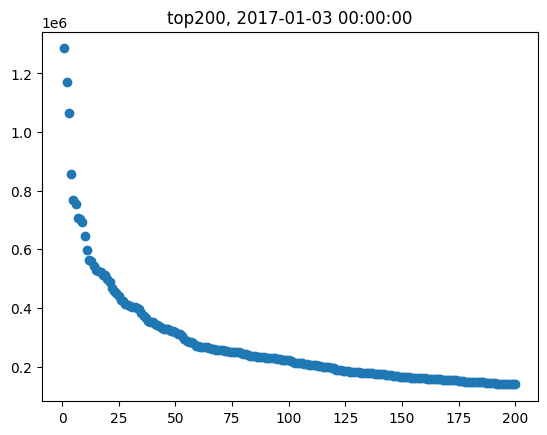

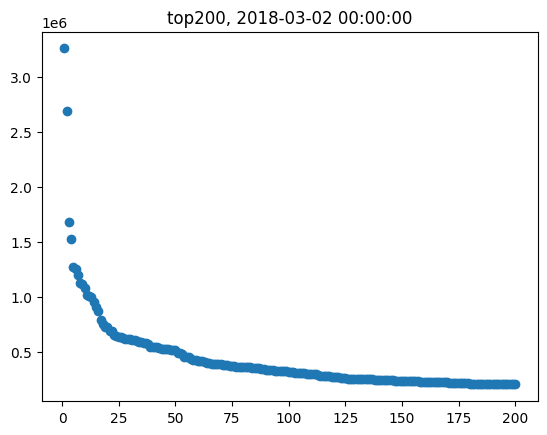

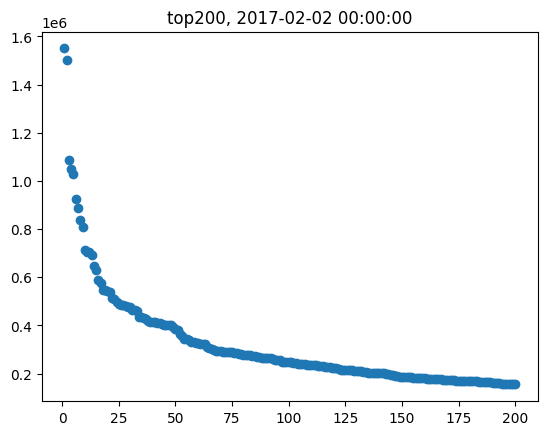

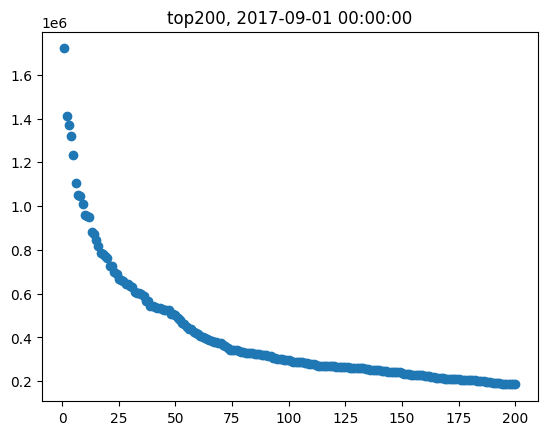

In [25]:
i = 0
for chart in ['top200']:
  for date in df['date'].unique():

    temp = df.query('date == @date').query('chart == @chart')

    fig, ax = plt.subplots()
    ax.scatter(temp['rank'], temp['streams'])
    plt.title(f'{chart}, {date}')
    plt.show()

    i+=1
    if i >=10:
      break

## 03_2 hist

top200

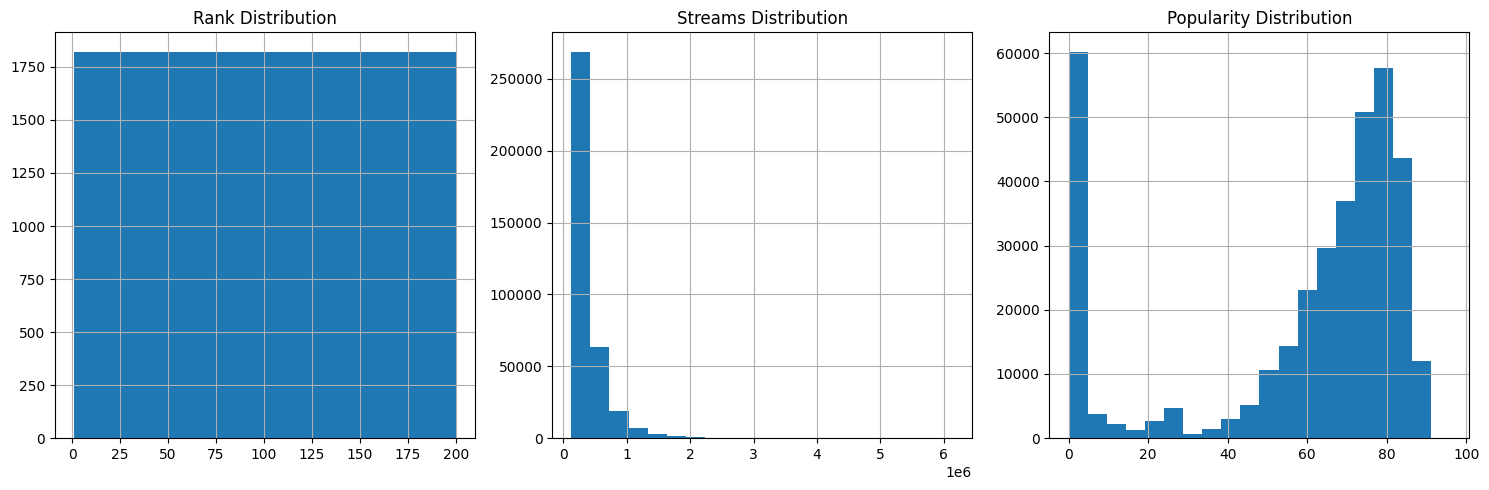

In [26]:
cols_for_hist = ['rank', 'streams', 'popularity']

fig, axes = plt.subplots(1, len(cols_for_hist), figsize=(15, 5))

for i, col in enumerate(cols_for_hist):
  if col == "rank":
    bins = 200
  else:
    bins = 20

  df.query('chart == "top200"')[col].hist(bins=bins, ax=axes[i])
  axes[i].set_title(col.capitalize() + ' Distribution')

plt.tight_layout()
plt.show()

viral50

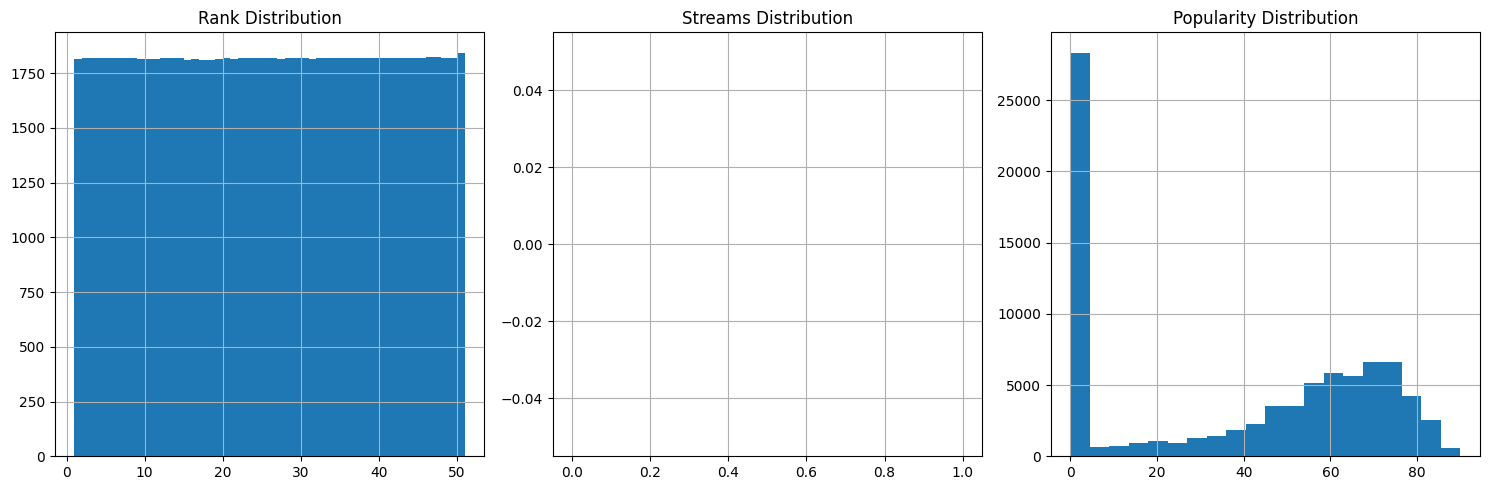

In [27]:
fig, axes = plt.subplots(1, len(cols_for_hist), figsize=(15, 5))
for i, col in enumerate(cols_for_hist):
  if col == "rank":
    bins = 50
  else:
    bins = 20
  df.query('chart == "viral50"')[col].hist(bins=bins, ax=axes[i])
  axes[i].set_title(col.capitalize() + ' Distribution')

plt.tight_layout()
plt.show()

# 04_data processing / exploratory

## 04_1 dtypes

In [28]:
df['date'] = pd.to_datetime(df['date'])

In [29]:
df.loc[:, ['date']].dtypes

date    datetime64[ns]
dtype: object

## 04_2 scatter

### 04_2_1 streams vs. rank by date since start

In [30]:
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days

df_viz = df.query('chart == "top200" and rank <= 50')

fig = px.scatter(df_viz, x='rank', y='streams', color='days_since_start', color_continuous_scale='viridis',
                 opacity=0.1, title='Streams vs Rank Colored by Date')

fig.update_layout(
    xaxis_title='Rank',
    yaxis_title='Streams',
    coloraxis_colorbar=dict(title='Days since start date')
)

fig.show()

## 04_3 number of available markets

tworzę nową kolumnę, która będzie zawierać ilość krajów, w których dostępny był utwór

In [31]:
for index, row in df.iterrows():
    if pd.isna(row['available_markets']):
        df.at[index, 'num_of_available_markets'] = 0
    elif row['available_markets'] == "[]":
        df.at[index, 'num_of_available_markets'] = 0
    else:
        original_string = row['available_markets']
        markets_list = original_string.split(", ")
        df.at[index, 'num_of_available_markets'] = len(markets_list)

In [32]:
df.head()

title  rank       date  \
0  Bad and Boujee (feat. Lil Uzi Vert)     1 2017-01-01   
1                            Fake Love     2 2017-01-01   
2                              Starboy     3 2017-01-01   
3                               Closer     4 2017-01-01   
4                        Black Beatles     5 2017-01-01   

                     artist  \
0                     Migos   
1                     Drake   
2     The Weeknd, Daft Punk   
3  The Chainsmokers, Halsey   
4  Rae Sremmurd, Gucci Mane   

                                                 url   chart          trend  \
0  https://open.spotify.com/track/4Km5HrUvYTaSUfi...  top200  SAME_POSITION   
1  https://open.spotify.com/track/343YBumqHu19cGo...  top200  SAME_POSITION   
2  https://open.spotify.com/track/5aAx2yezTd8zXrk...  top200  SAME_POSITION   
3  https://open.spotify.com/track/7BKLCZ1jbUBVqRi...  top200  SAME_POSITION   
4  https://open.spotify.com/track/6fujklziTHa8uoM...  top200  SAME_POSITION   

     streams                track_id                 album  popularity  \
0  1371493.0  4Km5HrUvYTaSUfiSGPJeQR               Culture         1.0   
1  1180074.0  343YBumqHu19cGoGARUTsd             More Life        73.0   
2  1064351.0  5aAx2yezTd8zXrkmtKl66Z               Starboy        23.0   
3  1010492.0  7BKLCZ1jbUBVqRi2FVlTVw                Closer        86.0   
4   874289.0  6fujklziTHa8uoM5OQSfIo  SremmLife 2 (Deluxe)        75.0   

   duration_ms explicit release_date  \
0     343150.0     True   2017-04-07   
1     210937.0     True   2017-03-18   
2     230453.0     True   2016-11-25   
3     244960.0    False   2016-07-29   
4     291893.0     True   2016-08-12   

                                   available_markets  af_danceability  \
0                                                 []            0.926   
1  ['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...            0.928   
2                                                 []            0.681   
3  ['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...            0.748   
4  ['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA...            0.794   

   af_energy  af_key  af_loudness  af_mode  af_speechiness  af_acousticness  \
0      0.666    11.0       -5.314      1.0          0.2440           0.0611   
1      0.481     9.0       -9.350      0.0          0.2870           0.1050   
2      0.594     7.0       -7.028      1.0          0.2820           0.1650   
3      0.524     8.0       -5.599      1.0          0.0338           0.4140   
4      0.632     0.0       -6.163      1.0          0.0649           0.1420   

   af_instrumentalness  af_liveness  af_valence  af_tempo  af_time_signature  \
0             0.000000        0.123       0.168   127.079                4.0   
1             0.000000        0.176       0.613   134.007                4.0   
2             0.000003        0.134       0.535   186.054                4.0   
3             0.000000        0.111       0.661    95.010                4.0   
4             0.000000        0.128       0.355   145.926                4.0   

   days_since_start  num_of_available_markets  
0                 0                       0.0  
1                 0                     184.0  
2                 0                       0.0  
3                 0                     185.0  
4                 0                     184.0

In [33]:
pd.set_option('display.max_rows', 100)

In [34]:
markets_value_counts = df['num_of_available_markets'].value_counts().sort_values(ascending=False)
markets_value_counts = markets_value_counts.drop(0)

## 04_4 af data

### 04_4_1 distribution by scalers

In [36]:
af_columns = ['af_danceability', 'af_energy', 'af_key', 'af_loudness',
              'af_mode', 'af_speechiness', 'af_acousticness', 'af_instrumentalness',
              'af_liveness', 'af_valence', 'af_tempo', 'af_time_signature']

In [37]:
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

In [38]:
df_minmax_scaled = df[af_columns].copy()
df_standard_scaled = df[af_columns].copy()

df_minmax_scaled[df_minmax_scaled.columns] = minmax_scaler.fit_transform(df_minmax_scaled[df_minmax_scaled.columns])
df_standard_scaled[df_standard_scaled.columns] = standard_scaler.fit_transform(df_standard_scaled[df_standard_scaled.columns])

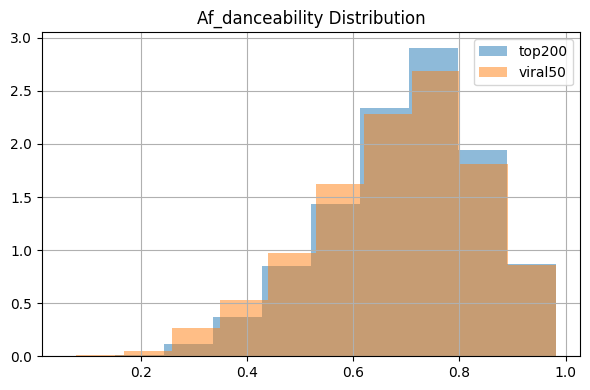

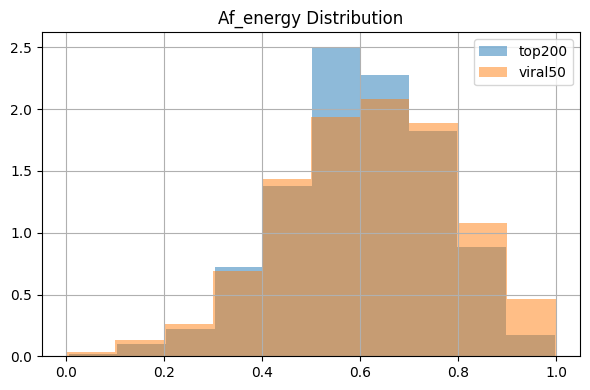

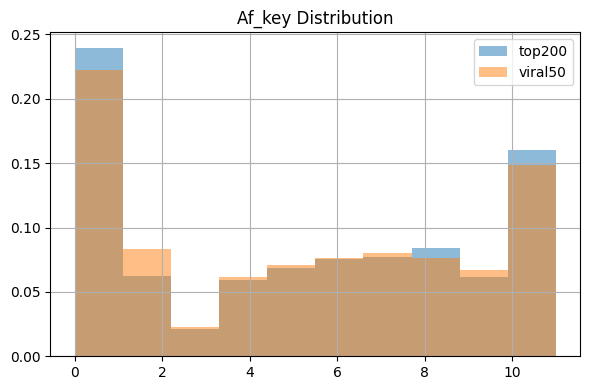

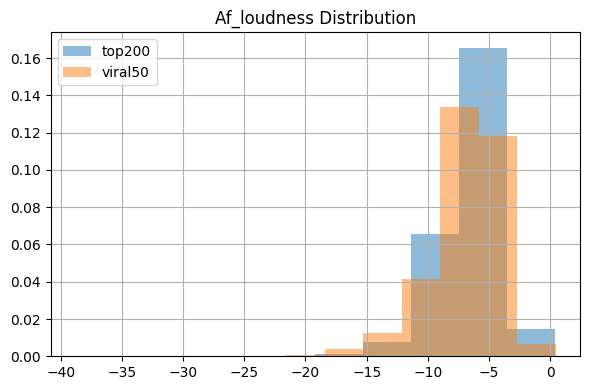

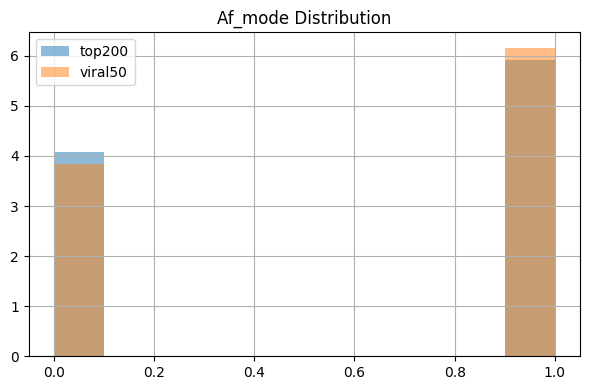

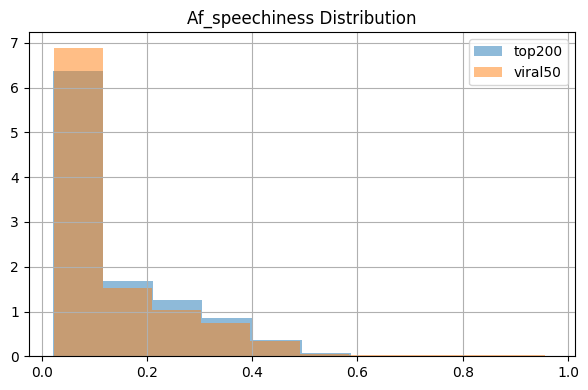

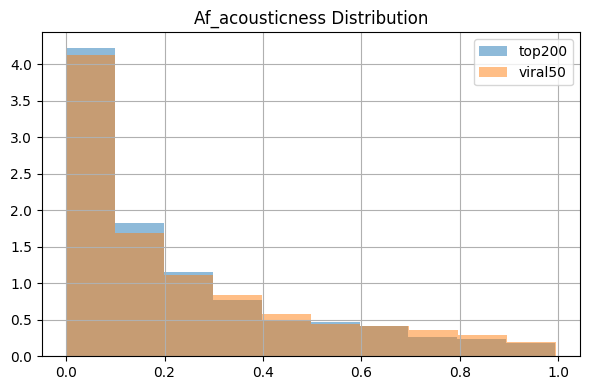

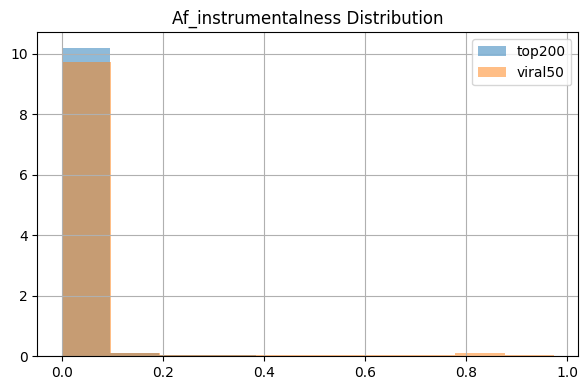

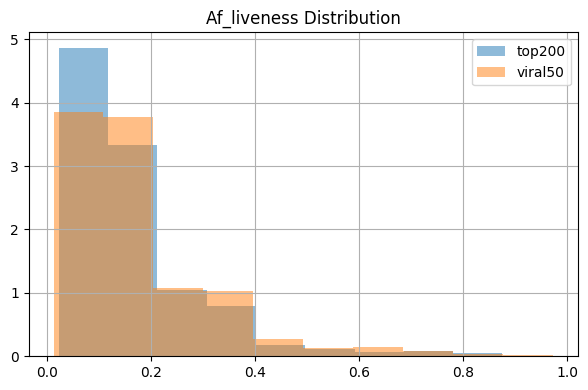

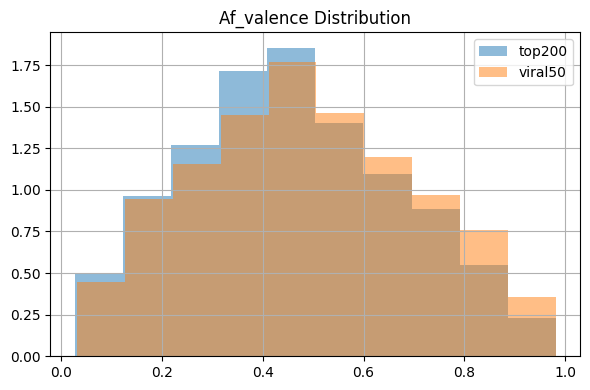

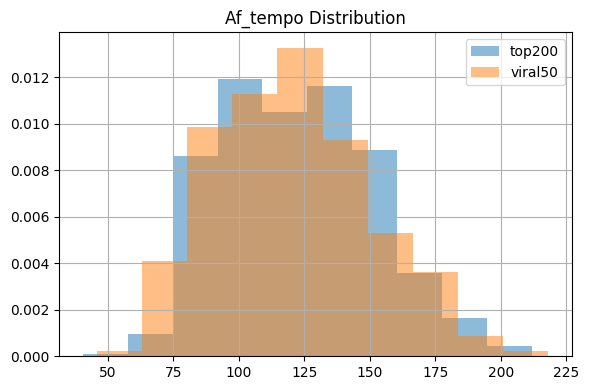

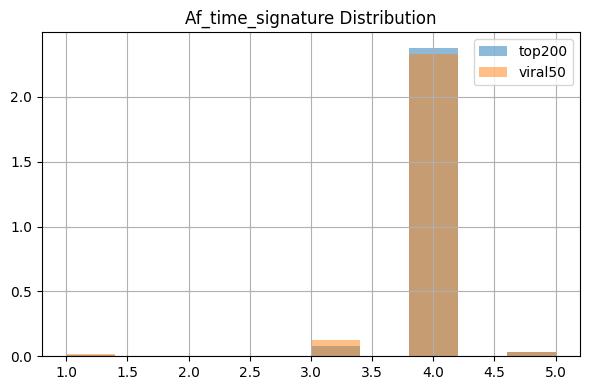

In [39]:
top200_df = df.query('chart == "top200"')
viral50_df = df.query('chart == "viral50"')

for col in af_columns:
    fig, ax = plt.subplots(figsize=(6, 4))
    top200_df[col].hist(bins=10, alpha=0.5, label='top200', ax=ax, density=True)
    viral50_df[col].hist(bins=10, alpha=0.5, label='viral50', ax=ax, density=True)
    plt.title(col.capitalize() + ' Distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()

### 04_4_2 heatmap

top200

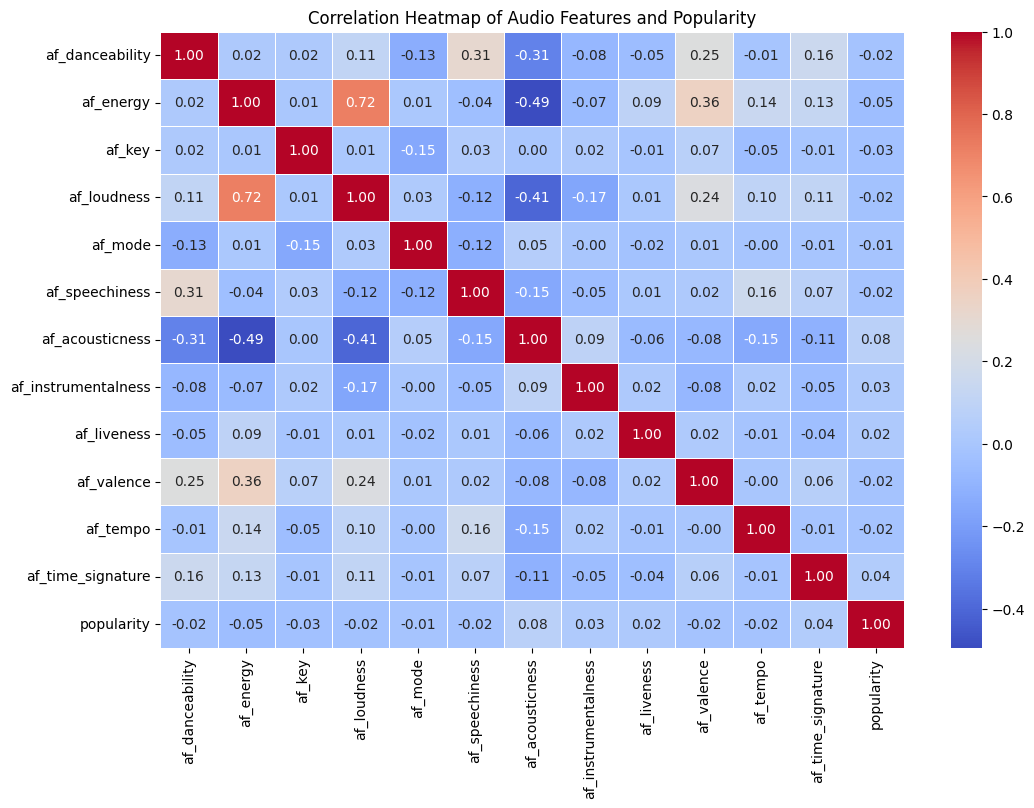

In [40]:
selected_columns = af_columns + ['popularity']

top200_df = df.query('chart == "top200"')
correlation_matrix = top200_df[selected_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Audio Features and Popularity')
plt.show()

viral50

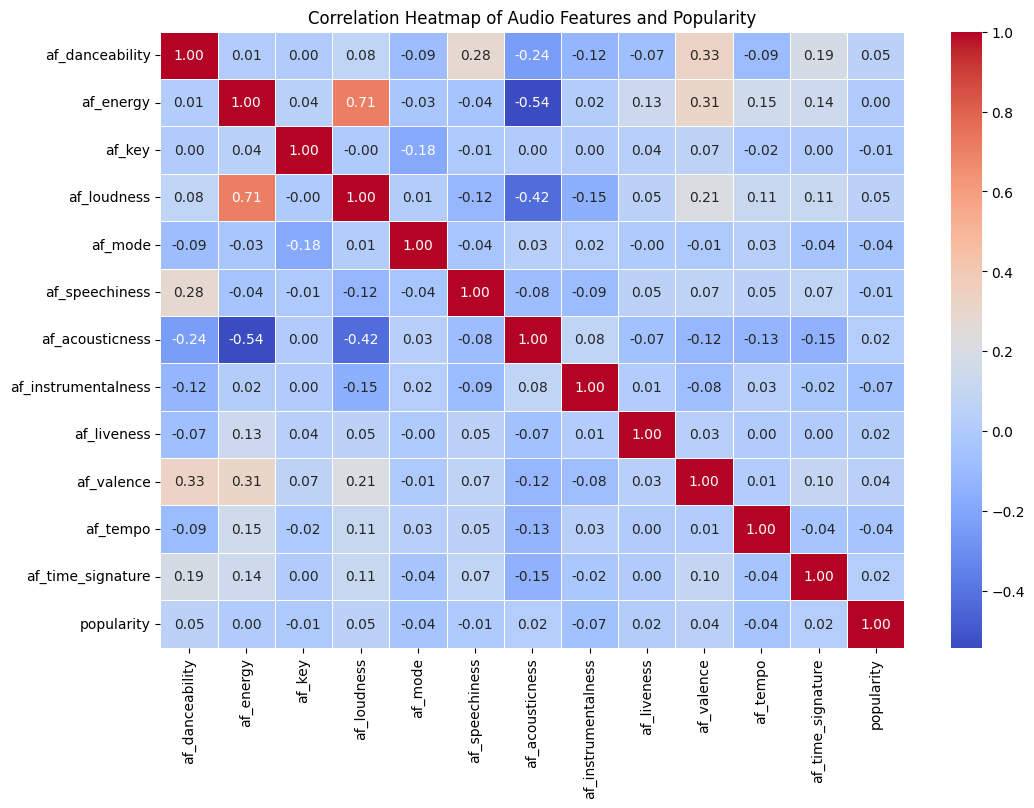

In [41]:
viral50_df = df.query('chart == "viral50"')
correlation_matrix = viral50_df[selected_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Audio Features and Popularity')
plt.show()

## 04_5 days on chart

In [42]:
grouped = df.groupby(['track_id', 'chart'])

In [43]:
days_on_chart = {}

for (track_id, chart), group in grouped:
    days_count = group['date'].nunique()
    days_on_chart[(track_id, chart)] = days_count

df['days_on_chart'] = np.nan

In [44]:
for index, row in df.iterrows():
    track_id = row['track_id']
    chart = row['chart']

    if (track_id, chart) in days_on_chart:
        days_count = days_on_chart[(track_id, chart)]
        df.loc[index, 'days_on_chart'] = days_count

## 04_6 fill track_id

In [45]:
df['track_id'].isna().sum()

7266

Dla brakujacych track id: wiemy, że url zawiera track id (22 znaki od prawej strony)

In [46]:
df['track_id'][0]

'4Km5HrUvYTaSUfiSGPJeQR'

In [47]:
df['url'][0]

'https://open.spotify.com/track/4Km5HrUvYTaSUfiSGPJeQR'

In [48]:
len(df['track_id'][0])

22

In [49]:
df[df['track_id'].isna()][['track_id', 'url']]

track_id                                                url
422256      NaN  https://open.spotify.com/track/5kfVgceWGfMZHjD...
422277      NaN  https://open.spotify.com/track/2d9hKKKQmGxckny...
422292      NaN  https://open.spotify.com/track/3YcloPAR8p3hlHK...
422318      NaN  https://open.spotify.com/track/0Jwqf8WzYlEtywz...
422330      NaN  https://open.spotify.com/track/2WGzDLofKXzEUV2...
...         ...                                                ...
455067      NaN  https://open.spotify.com/track/3svmi1v7HMlyYb7...
455068      NaN  https://open.spotify.com/track/2dQa4RNT22zCHGS...
455069      NaN  https://open.spotify.com/track/6T3sH1EuBMijU1M...
455072      NaN  https://open.spotify.com/track/06nKF46jG8p1zwy...
455074      NaN  https://open.spotify.com/track/4ULs3UigRxfcUZ1...

[7266 rows x 2 columns]

In [50]:
df_track_id = df[df['track_id'].isna()]
df_track_id

title  rank       date  \
422256     Kill for Candy     2 2017-03-06   
422277  Too Much Too Late    23 2017-03-06   
422292            Coexist    38 2017-03-06   
422318      Welcome to LA    14 2017-06-01   
422330              Vacay    26 2017-06-01   
...                   ...   ...        ...   
455067      Fahrradsattel    33 2021-07-31   
455068         Antisocial    34 2021-07-31   
455069           in heat.    35 2021-07-31   
455072              Pears    38 2021-07-31   
455074       Antisocial 2    40 2021-07-31   

                                                   artist  \
422256                                           DREAMCAR   
422277                                    Sabrina Claudio   
422292                                         Have Mercy   
422318                                        Oliver Tree   
422330                                       Sunny & Gabe   
...                                                   ...   
455067                                              Pisse   
455068                               Slump6s, BabySantana   
455069                                      Hentai Xander   
455072                                      Weston Estate   
455074  BabySantana, Slump6s, Yung Fazo, Xhulooo, SSGKobe   

                                                      url    chart      trend  \
422256  https://open.spotify.com/track/5kfVgceWGfMZHjD...  viral50  NEW_ENTRY   
422277  https://open.spotify.com/track/2d9hKKKQmGxckny...  viral50  NEW_ENTRY   
422292  https://open.spotify.com/track/3YcloPAR8p3hlHK...  viral50  NEW_ENTRY   
422318  https://open.spotify.com/track/0Jwqf8WzYlEtywz...  viral50    MOVE_UP   
422330  https://open.spotify.com/track/2WGzDLofKXzEUV2...  viral50    MOVE_UP   
...                                                   ...      ...        ...   
455067  https://open.spotify.com/track/3svmi1v7HMlyYb7...  viral50  MOVE_DOWN   
455068  https://open.spotify.com/track/2dQa4RNT22zCHGS...  viral50    MOVE_UP   
455069  https://open.spotify.com/track/6T3sH1EuBMijU1M...  viral50  MOVE_DOWN   
455072  https://open.spotify.com/track/06nKF46jG8p1zwy...  viral50  MOVE_DOWN   
455074  https://open.spotify.com/track/4ULs3UigRxfcUZ1...  viral50  MOVE_DOWN   

        streams track_id album  popularity  duration_ms explicit release_date  \
422256      NaN      NaN   NaN         NaN          NaN      NaN          NaN   
422277      NaN      NaN   NaN         NaN          NaN      NaN          NaN   
422292      NaN      NaN   NaN         NaN          NaN      NaN          NaN   
422318      NaN      NaN   NaN         NaN          NaN      NaN          NaN   
422330      NaN      NaN   NaN         NaN          NaN      NaN          NaN   
...         ...      ...   ...         ...          ...      ...          ...   
455067      NaN      NaN   NaN         NaN          NaN      NaN          NaN   
455068      NaN      NaN   NaN         NaN          NaN      NaN          NaN   
455069      NaN      NaN   NaN         NaN          NaN      NaN          NaN   
455072      NaN      NaN   NaN         NaN          NaN      NaN          NaN   
455074      NaN      NaN   NaN         NaN          NaN      NaN          NaN   

       available_markets  af_danceability  af_energy  af_key  af_loudness  \
422256               NaN              NaN        NaN     NaN          NaN   
422277               NaN              NaN        NaN     NaN          NaN   
422292               NaN              NaN        NaN     NaN          NaN   
422318               NaN              NaN        NaN     NaN          NaN   
422330               NaN              NaN        NaN     NaN          NaN   
...                  ...              ...        ...     ...          ...   
455067               NaN              NaN        NaN     NaN          NaN   
455068               NaN              NaN        NaN     NaN          NaN   
455069               NaN              NaN        NaN     NaN          NaN   
455072            

In [51]:
df.groupby(['artist', 'title']).size().reset_index().sort_values(0)

artist                title     0
6341   Leonell Cassio, Anne Lan             Same Red     1
10533                      TOOL        Forty Six & 2     1
3855                     Future         Tricks on Me     1
10530                      TOOL       Culling Voices     1
10529                      TOOL  Chocolate Chip Trip     1
...                         ...                  ...   ...
5331                 Juice WRLD         Lucid Dreams  1419
4681                    J. Cole       No Role Modelz  1474
6724               Lil Uzi Vert        XO Tour Llif3  1549
12029              XXXTENTACION       Jocelyn Flores  1590
11415              Travis Scott           goosebumps  1778

[12683 rows x 3 columns]

In [52]:
df.query('artist == "Travis Scott"').query('title == "goosebumps"')['url'].unique()

array(['https://open.spotify.com/track/6gBFPUFcJLzWGx4lenP6h2'],
      dtype=object)

zastępuję brakujące track_id 22 znakami od prawej strony z url

In [53]:
df['track_id'] = df['url'].str[-22:]

In [54]:
df_for_modeling = df.copy()

## 04_7 song life cycle

In [55]:
top200_track_counts = df[df['chart'] == 'top200']['track_id'].value_counts()
viral50_track_counts = df[df['chart'] == 'viral50']['track_id'].value_counts()

selected_track_ids = set(top200_track_counts[top200_track_counts >= 1000].index) & set(viral50_track_counts[viral50_track_counts >= 10].index) & set(df[df['popularity'] >= 75]['track_id'])

filtered_df = df[df['track_id'].isin(selected_track_ids)]

In [56]:
filtered_df['track_id'].nunique()

9

In [57]:
top200_df = filtered_df[filtered_df['chart'] == 'top200']
viral50_df = filtered_df[filtered_df['chart'] == 'viral50']

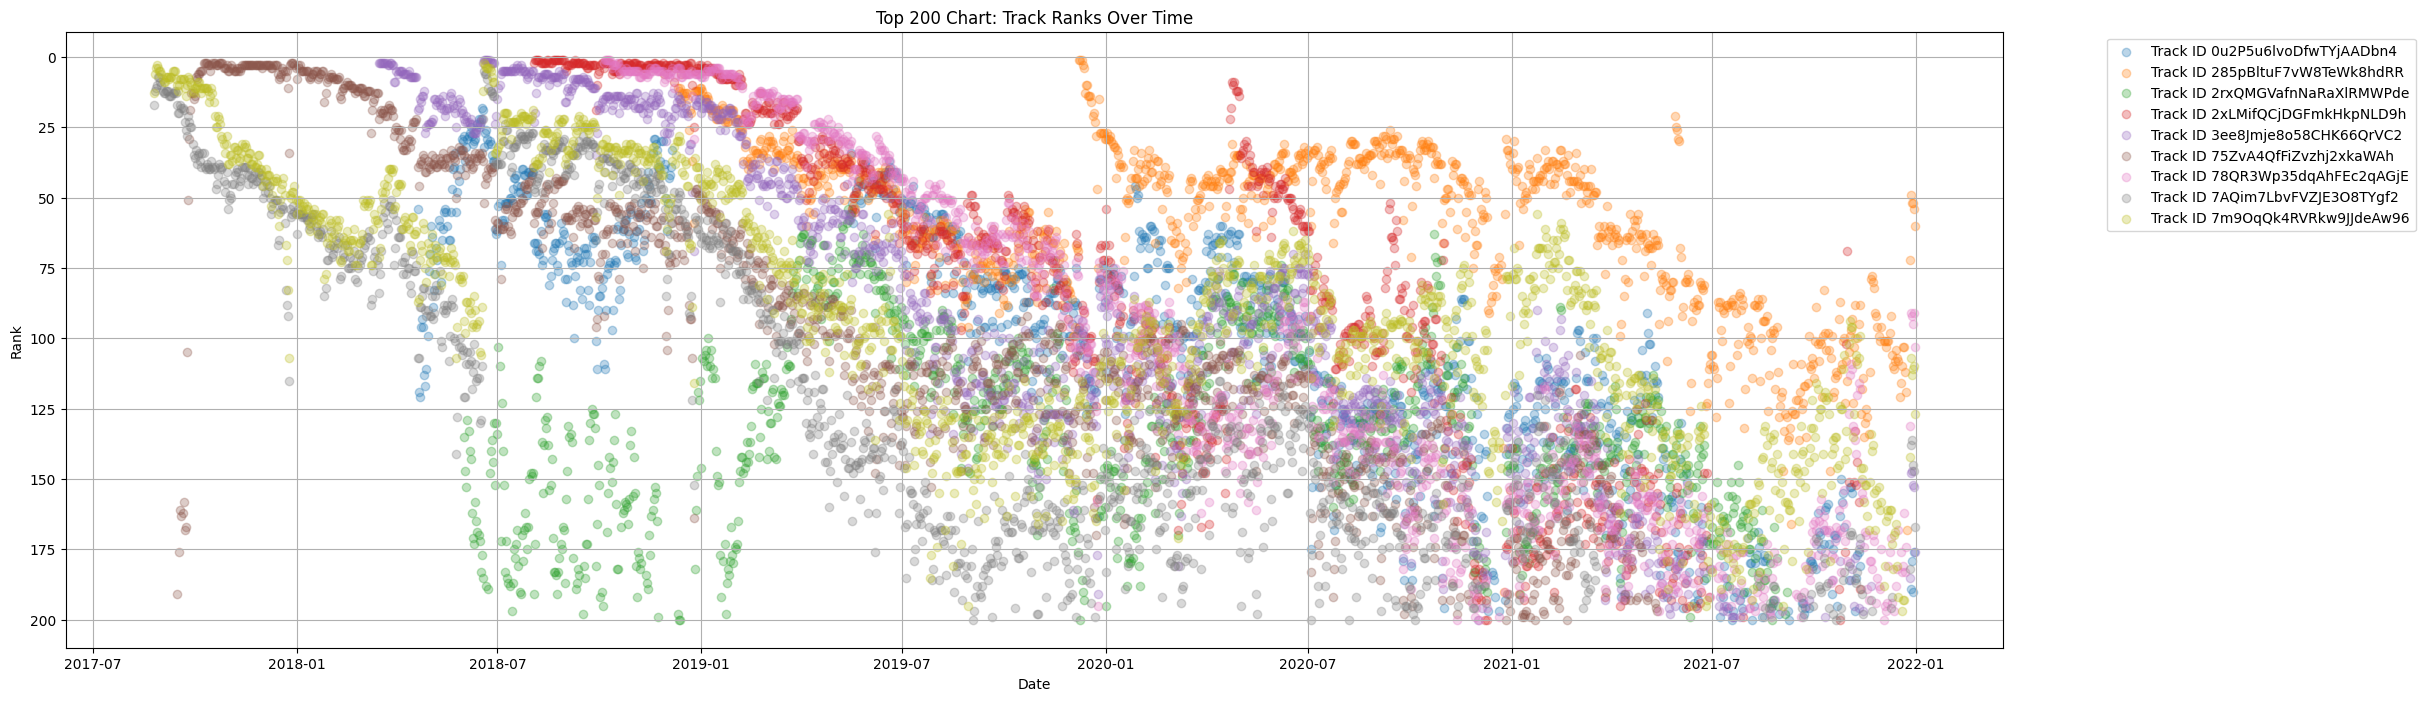

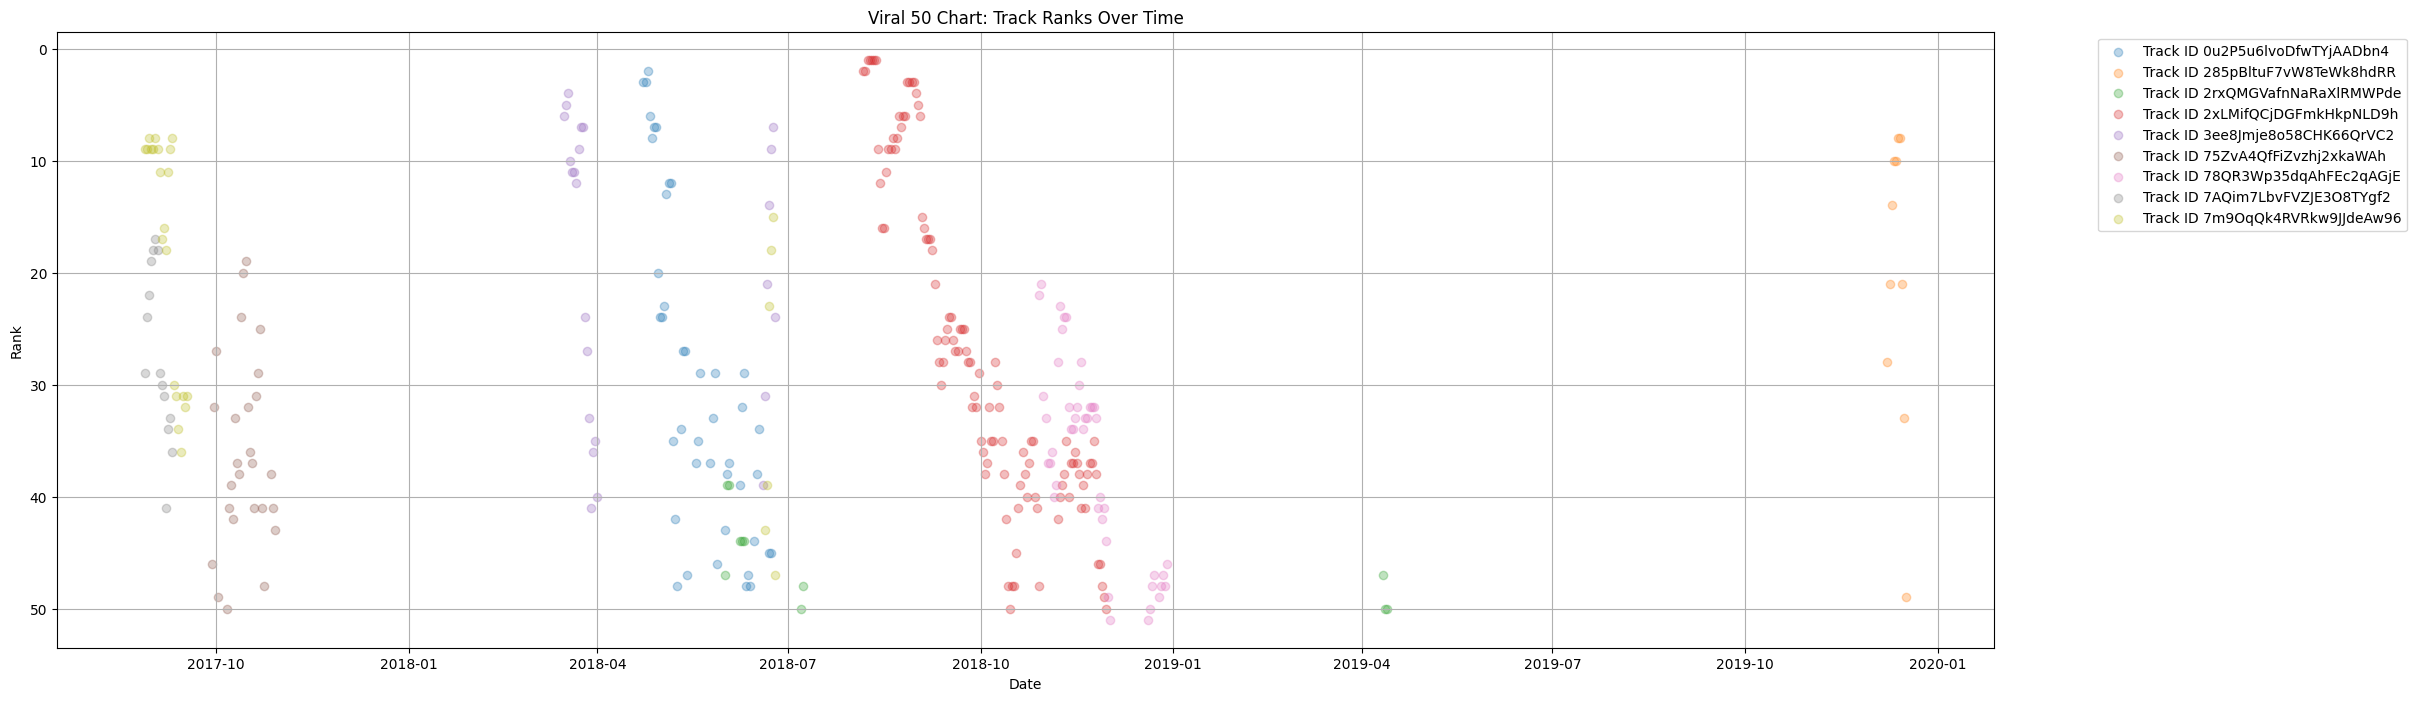

In [58]:
# top200_df
plt.figure(figsize=(25, 8))
for track_id, group in top200_df.groupby('track_id'):
  plt.scatter(group['date'], group['rank'], label=f'Track ID {track_id}', alpha=0.3)
plt.gca().invert_yaxis()
plt.xlabel('Date')
plt.ylabel('Rank')
plt.title('Top 200 Chart: Track Ranks Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# viral50_df
plt.figure(figsize=(25, 8))
for track_id, group in viral50_df.groupby('track_id'):
    plt.scatter(group['date'], group['rank'], label=f'Track ID {track_id}', alpha=0.3)
plt.gca().invert_yaxis()
plt.xlabel('Date')
plt.ylabel('Rank')
plt.title('Viral 50 Chart: Track Ranks Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

same chart but with popularity scale

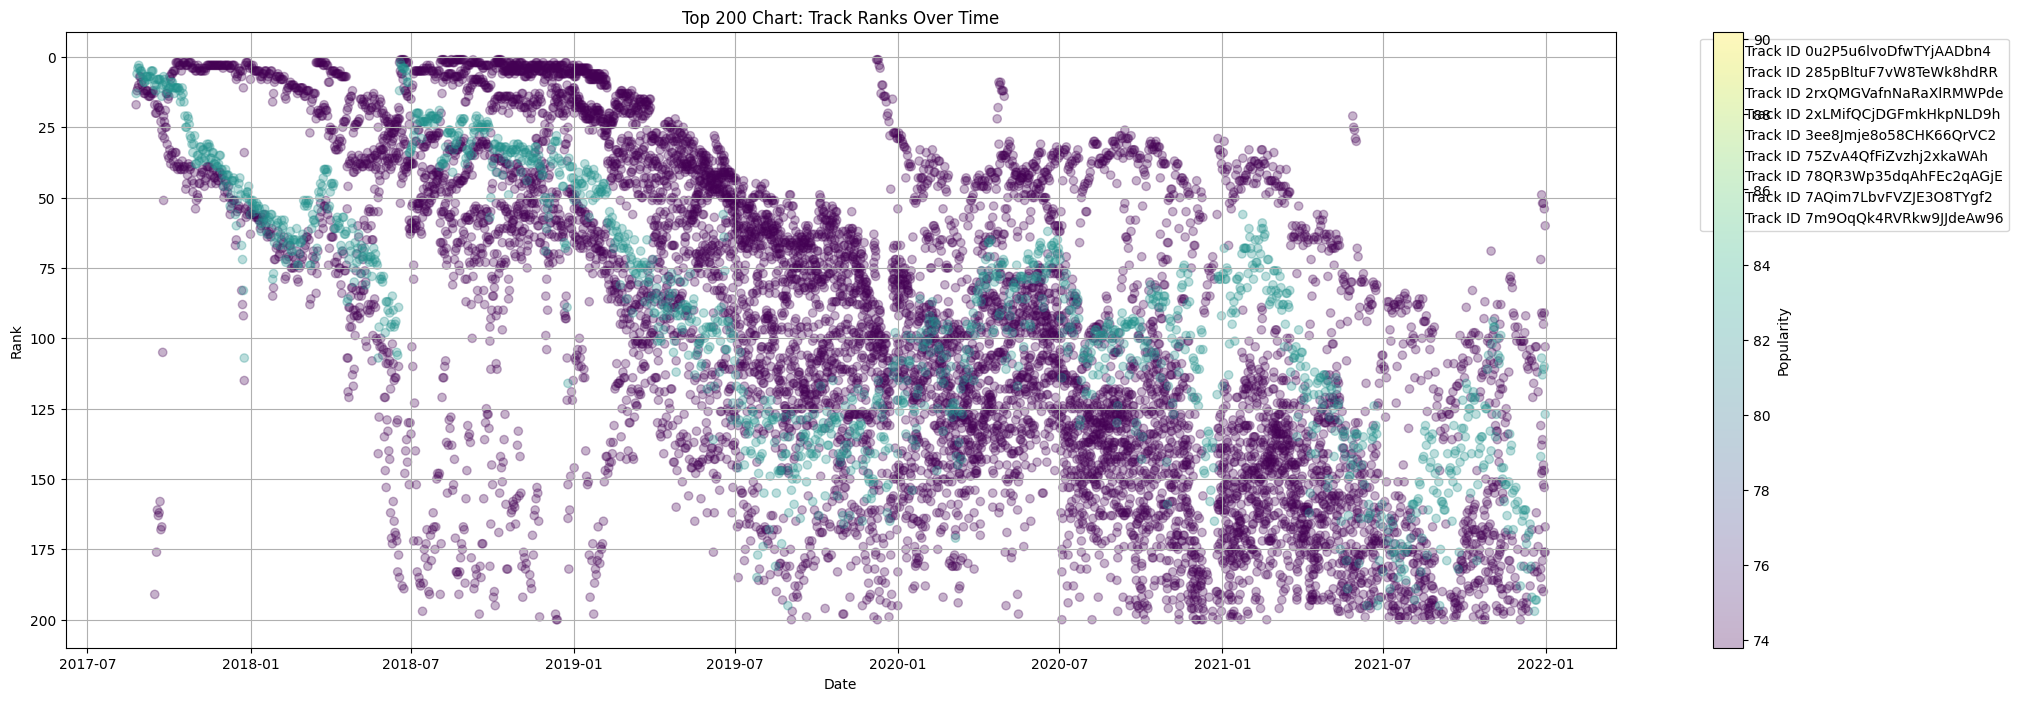

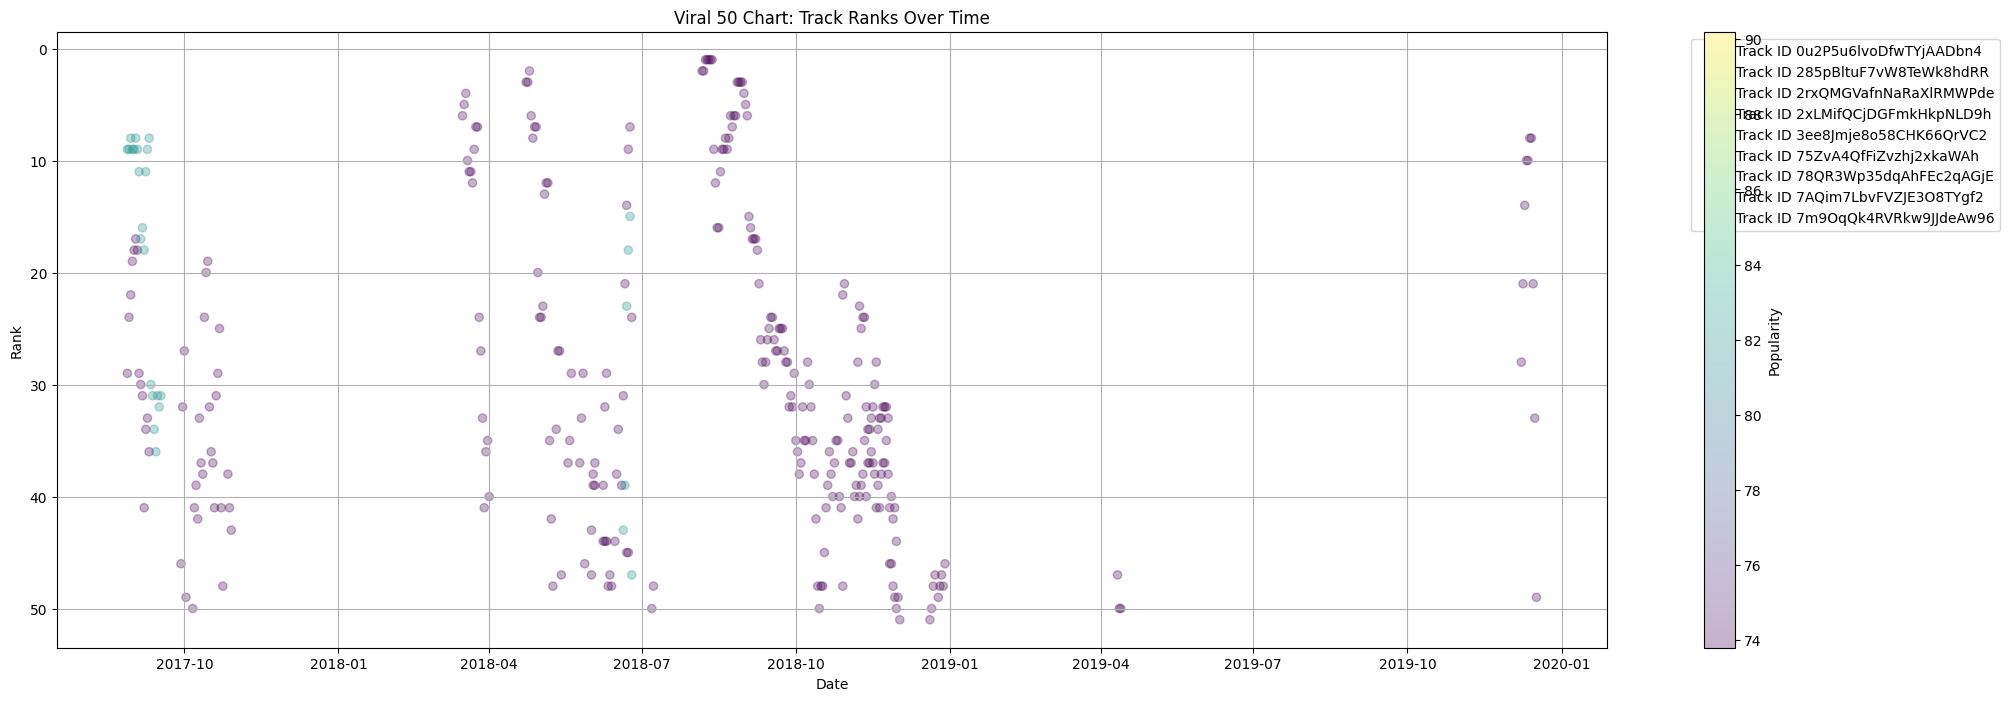

In [59]:
# top200_df
plt.figure(figsize=(25, 8))
for track_id, group in top200_df.groupby('track_id'):
  plt.scatter(group['date'], group['rank'], c=group['popularity'], cmap='viridis', label=f'Track ID {track_id}', alpha=0.3)
plt.gca().invert_yaxis()
plt.xlabel('Date')
plt.ylabel('Rank')
plt.title('Top 200 Chart: Track Ranks Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.colorbar(label='Popularity')
plt.grid(True)
plt.show()

# viral50_df
plt.figure(figsize=(25, 8))
for track_id, group in viral50_df.groupby('track_id'):
    plt.scatter(group['date'], group['rank'], c=group['popularity'], cmap='viridis', label=f'Track ID {track_id}', alpha=0.3)
plt.gca().invert_yaxis()
plt.xlabel('Date')
plt.ylabel('Rank')
plt.title('Viral 50 Chart: Track Ranks Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.colorbar(label='Popularity')
plt.grid(True)
plt.show()

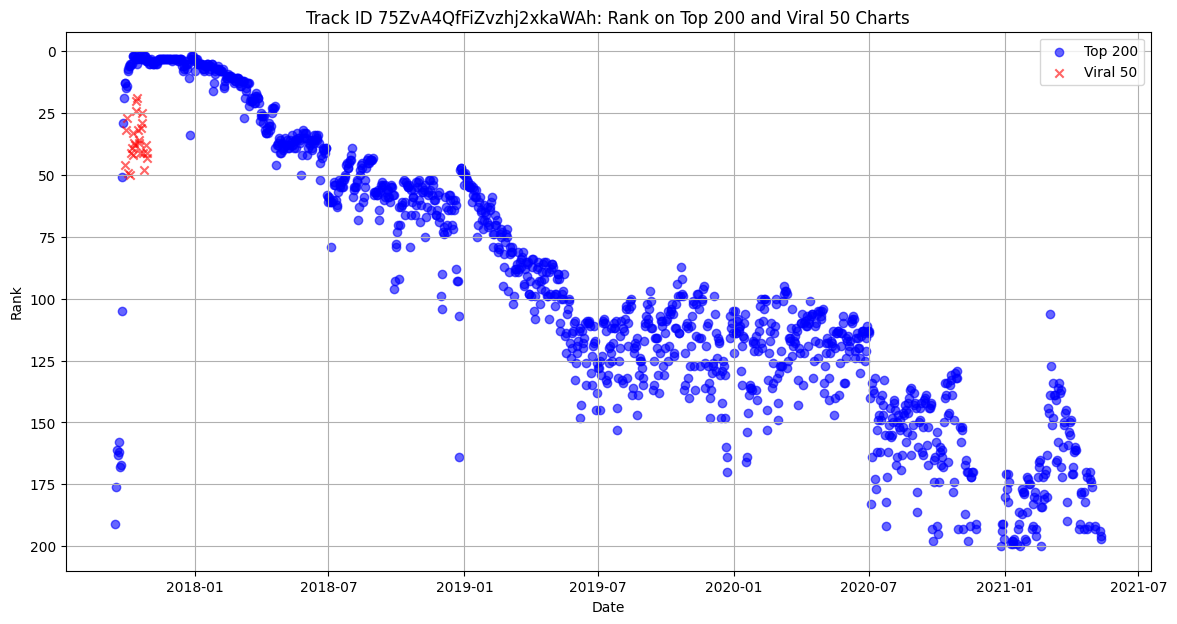

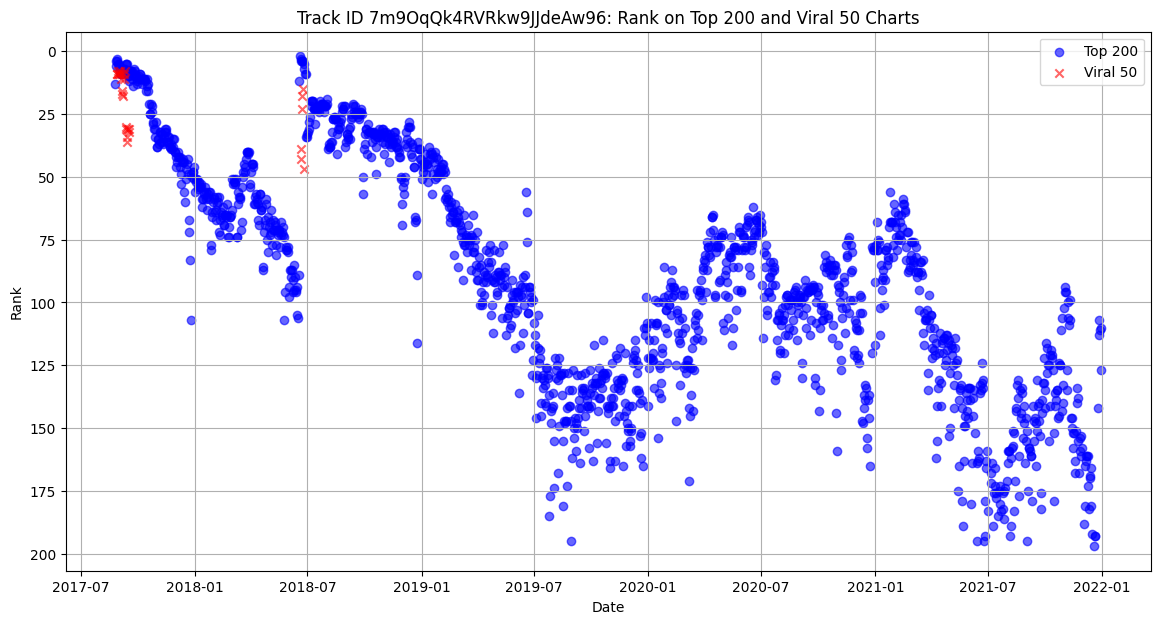

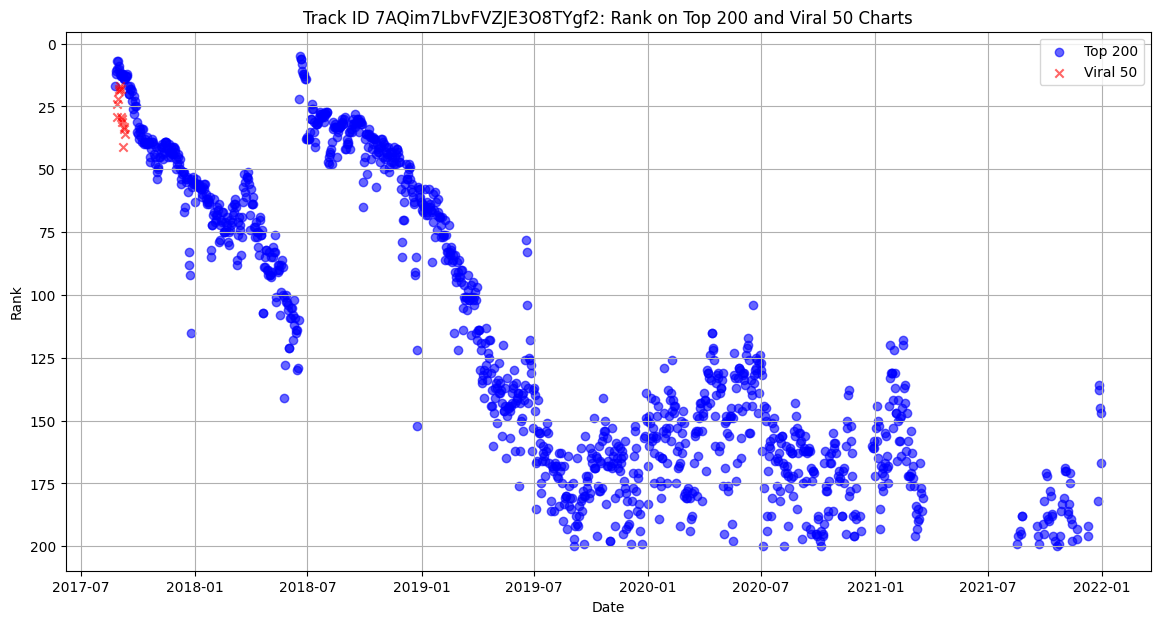

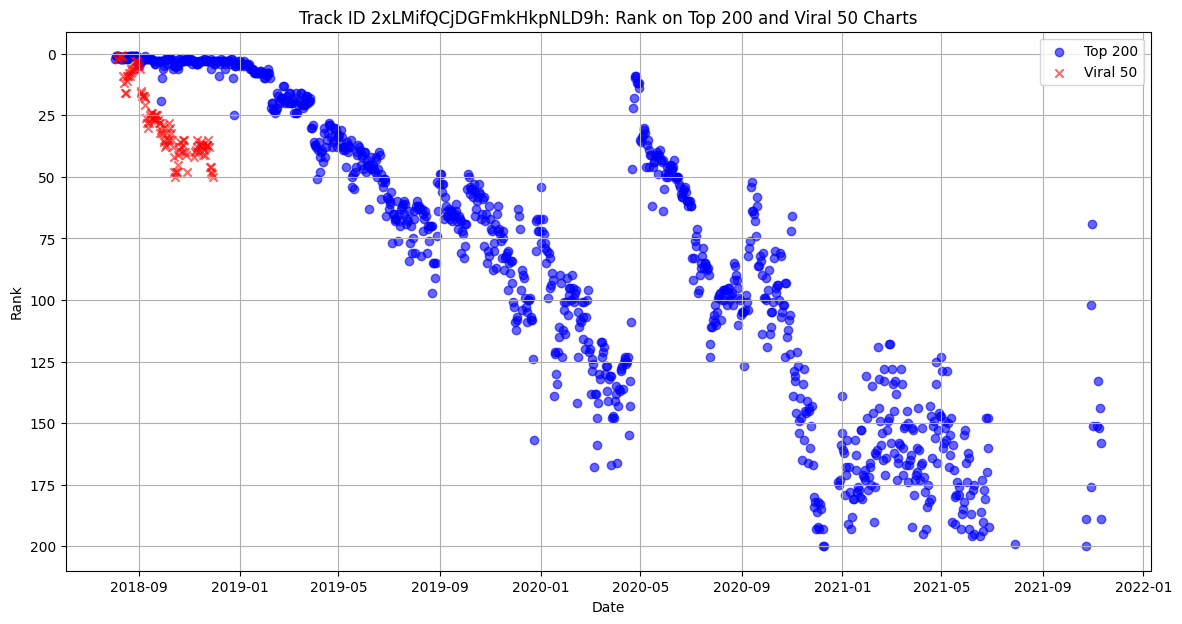

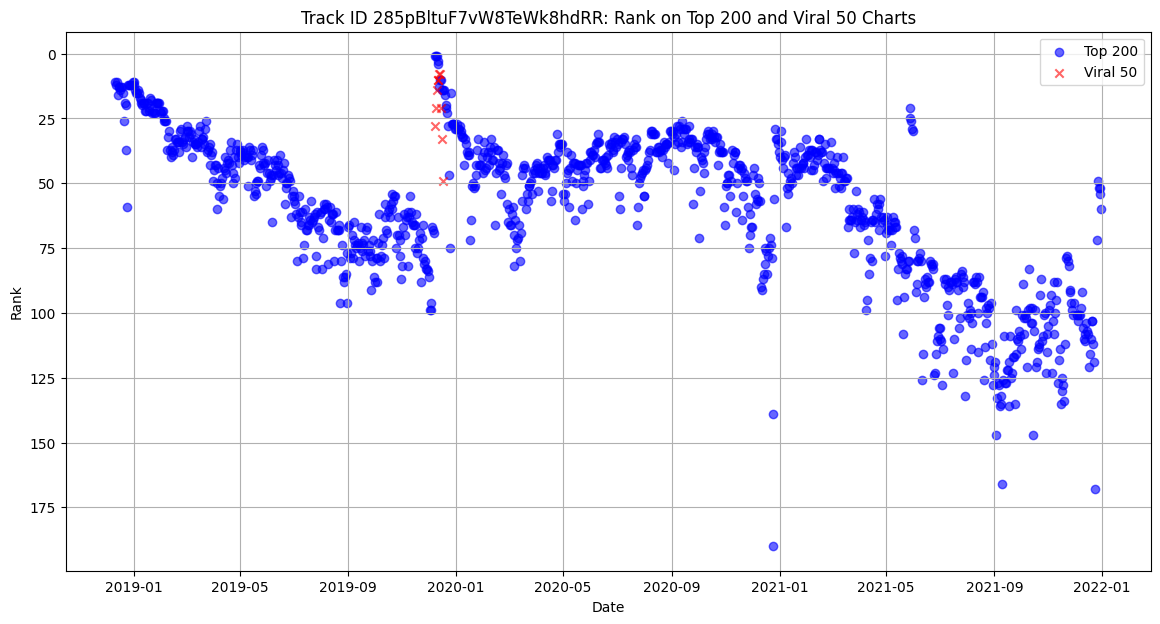

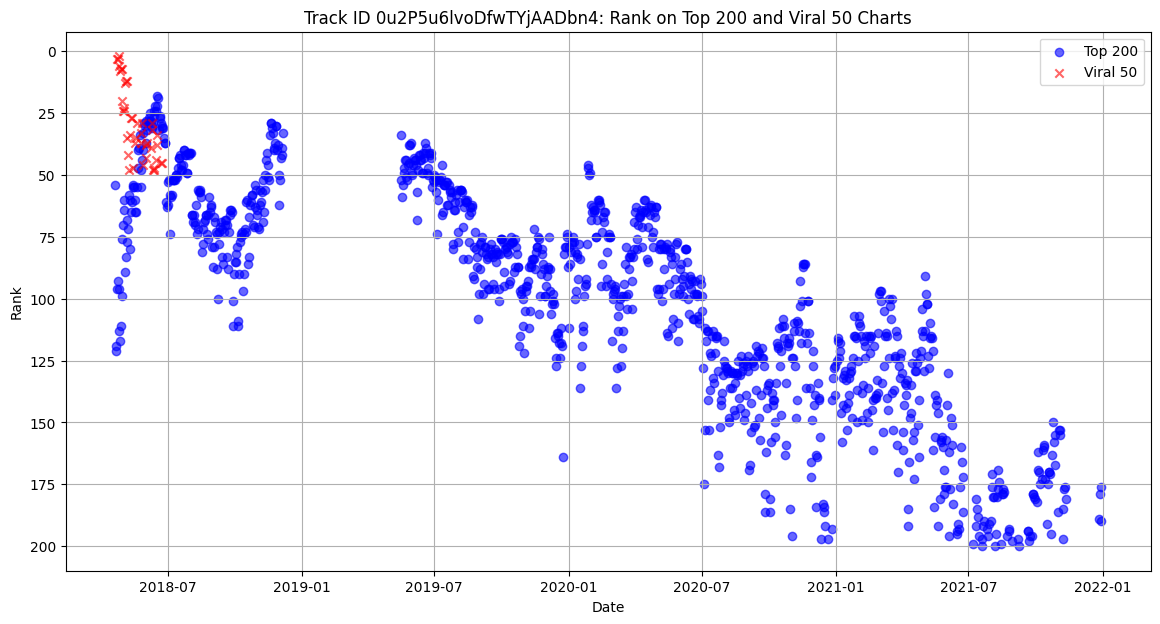

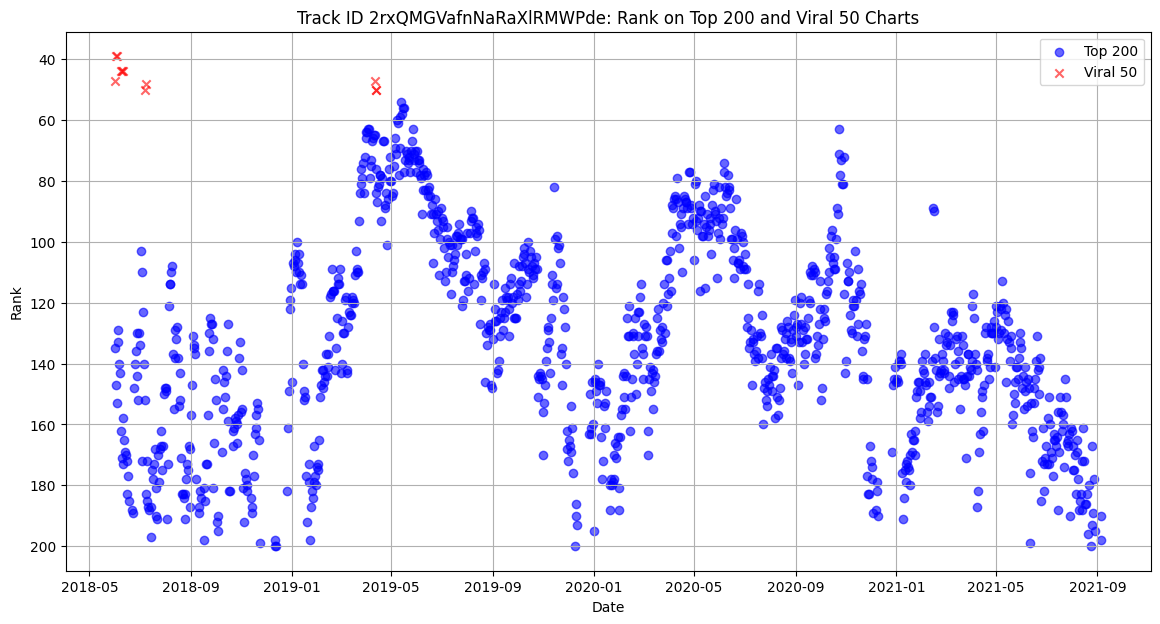

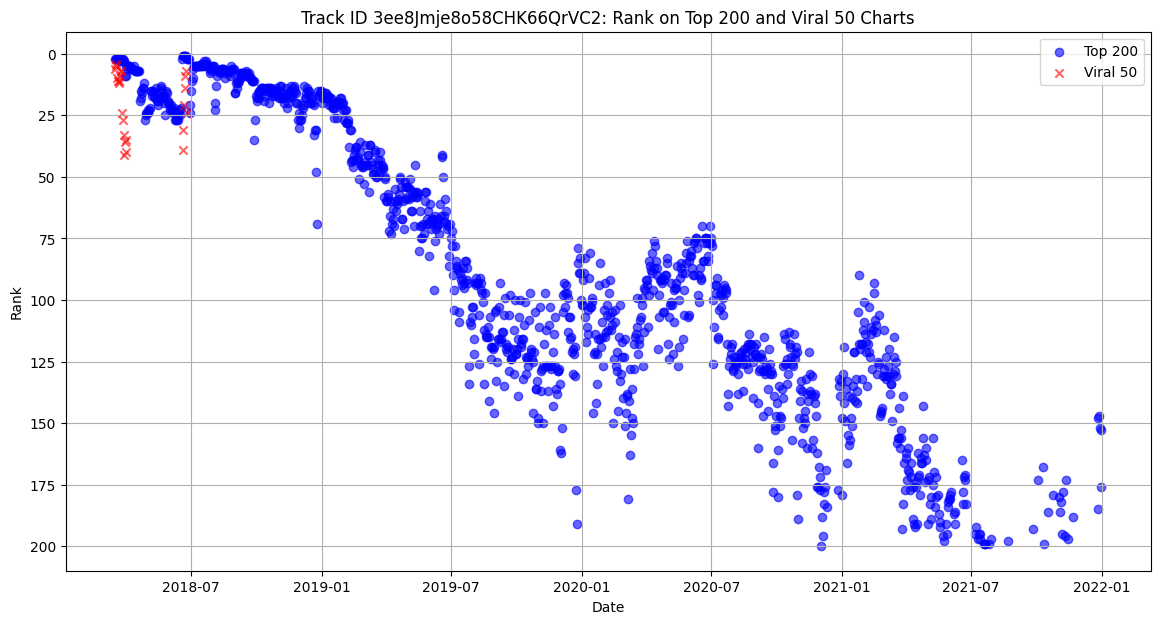

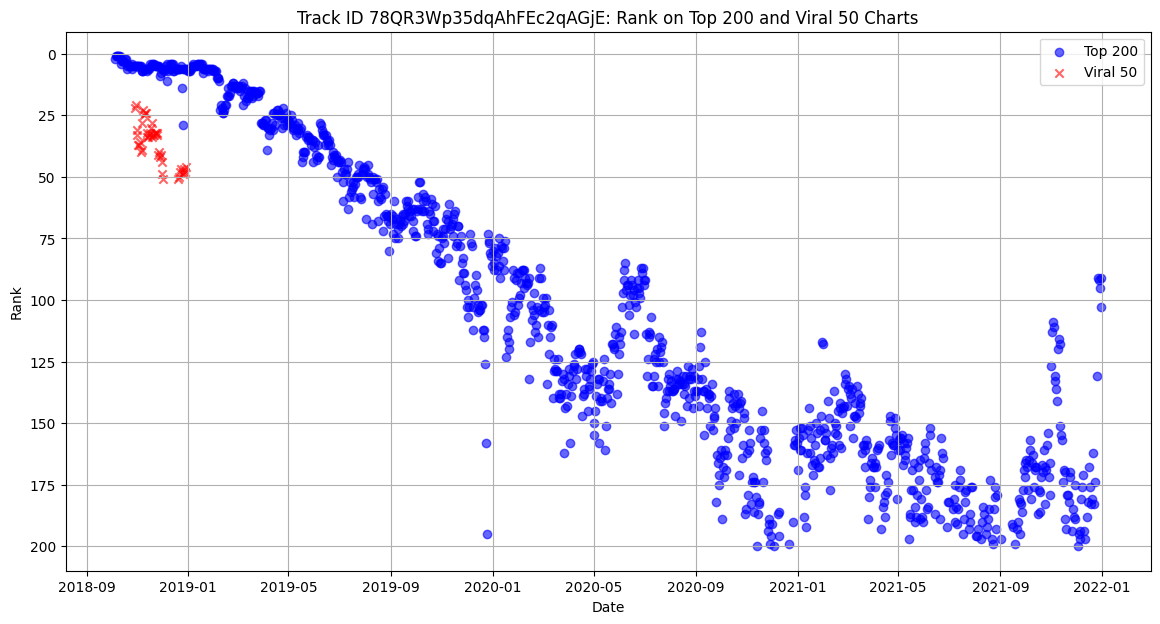

In [60]:
for track_id in filtered_df['track_id'].unique():
    track_data = filtered_df[filtered_df['track_id'] == track_id]

    top200_data = track_data[track_data['chart'] == 'top200']
    viral50_data = track_data[track_data['chart'] == 'viral50']

    plt.figure(figsize=(14, 7))

    if not top200_data.empty:
        plt.scatter(top200_data['date'], top200_data['rank'], marker='o', color='b', label='Top 200', alpha=0.6)

    if not viral50_data.empty:
        plt.scatter(viral50_data['date'], viral50_data['rank'], marker='x', color='r', label='Viral 50', alpha=0.6)

    plt.gca().invert_yaxis()
    plt.xlabel('Date')
    plt.ylabel('Rank')
    plt.title(f'Track ID {track_id}: Rank on Top 200 and Viral 50 Charts')
    plt.legend()
    plt.grid(True)
    plt.show()

# 05_data processing / modelling

## 05_1 drop

rezygnuję z kolumn, z których nie mogę skorzystać, albo uważam za nie wnoszące informacji

In [61]:
df.drop(columns=['url', 'trend', 'available_markets', 'date', 'release_date', 'title'], axis=1, inplace=True)

## 05_2 encoding

### 05_2_1 label encoder

chart encoding

In [62]:
slownik = {'viral50': 1,
           'top200': 0}

df['chart'] = df['chart'].map(slownik)

categorical columns

In [63]:
categorical_columns = ['artist', 'track_id', 'album', 'explicit']

In [64]:
le = LabelEncoder()
label_encoded_df = df[categorical_columns].copy()

for col in label_encoded_df.select_dtypes(include='O').columns:
    label_encoded_df[col]=le.fit_transform(label_encoded_df[col])

In [65]:
df.drop(columns=categorical_columns, axis=1, inplace=True)

In [66]:
df = pd.concat([df, label_encoded_df], axis=1)

## 05_3 scaler

In [67]:
columns_to_scale = ['streams', 'duration_ms', 'artist', 'track_id', 'album']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[columns_to_scale])

scaled_df = pd.DataFrame(scaled_features, columns=columns_to_scale)
df = pd.concat([scaled_df, df.drop(columns=columns_to_scale)], axis=1)

# 06_models

In [69]:
top200_df = df[df['chart'] == 0].reset_index(drop=True)

viral50

In [70]:
viral50_df = df[df['chart'] == 1].reset_index(drop=True)
viral50_df = viral50_df.drop(columns=['streams'])

In [71]:
top200_df = top200_df.drop_duplicates(subset = 'track_id', keep = 'first')
viral50_df = viral50_df.drop_duplicates(subset = 'track_id', keep = 'first')

## 06_1 popularity prediction top200


### 06_1_1 grid search

In [74]:
top200_df = top200_df.head(1000)

X = top200_df.drop(columns=['popularity'])
y = top200_df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.columns = X_train.columns.astype(str)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_regressor = RandomForestRegressor(random_state=42)
grid_search_200 = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_200.fit(X_train, y_train)

print("Best Parameters:", grid_search_200.best_params_)
best_rf_model_200 = grid_search_200.best_estimator_

test_score_200 = best_rf_model_200.score(X_test, y_test)
print("Test Score (R^2):", test_score_200)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



Best Parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 200}
Test Score (R^2): 0.892893251409544


In [75]:
best_rf_model_200

RandomForestRegressor(max_depth=20, max_features='auto', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=200, random_state=42)

### 06_1_2 plotting tree

In [77]:
single_tree = best_rf_model_200.estimators_[0]

plt.figure(figsize=(400, 50))
plot_tree(single_tree, feature_names=X_train.columns, filled=True, fontsize=10)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### 06_1_3 metrics

In [78]:
y_pred = best_rf_model_200.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('R2: ', r2)

MSE:  90.50271500469925
RMSE:  9.513291491628923
MAE:  6.463460215116089
R2:  0.892893251409544


## 06_2 popularity prediction viral50

### 06_2_1 grid search

In [79]:
viral50_df = viral50_df.head(1000)

X = viral50_df.drop(columns=['popularity'])
y = viral50_df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.columns = X_train.columns.astype(str)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_regressor = RandomForestRegressor(random_state=42)
grid_search_50 = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_50.fit(X_train, y_train)

print("Best Parameters:", grid_search_50.best_params_)
best_rf_model_50 = grid_search_50.best_estimator_

test_score_50 = best_rf_model_50.score(X_test, y_test)
print("Test Score (R^2):", test_score_50)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



Best Parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Test Score (R^2): 0.7513296110016324


In [80]:
best_rf_model_50

RandomForestRegressor(max_depth=20, max_features='auto', min_samples_leaf=2,
                      min_samples_split=5, random_state=42)

### 06_2_2 plot_tree

In [81]:
single_tree = best_rf_model_50.estimators_[0]

plt.figure(figsize=(400, 50))
plot_tree(single_tree, feature_names=X_train.columns, filled=True, fontsize=10)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### 06_2_3 metrics

In [82]:
y_pred = best_rf_model_50.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('R2: ', r2)

MSE:  181.50250269975757
RMSE:  13.472286468887068
MAE:  8.376018645881144
R2:  0.7513296110016324
